<img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Microsoft%20Malware%20Prediction/Microsoft_logo.png" width="600" height="170">
<h1><center>Microsoft Malware Prediction</center></h1>
<h2><center>Can you predict if a machine will soon be hit with malware?</center></h2>

### Content:
* [Exploratory Data Analysis [1st part, raw data]](#Exploratory-Data-Analysis-[1st-part,-raw-data])
* [Pre process](#Pre-process)
* [Exploratory Data Analysis [2nd part, clean data]](#Exploratory-Data-Analysis-[2nd-part,-clean-data])
* [Process data for LGB model](#Process-data-for-LGB-model)
* [Model training](#Model-training)
* [Predictions](#Predictions)
* [Results](#Output-results)

#### Checkout the second part of this EDA on [this kernel](https://www.kaggle.com/dimitreoliveira/malware-detection-extended-eda/notebook)

### Dependencies

In [1]:
import dask
import dask.dataframe as dd
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

### Load data

In [3]:
train = dd.read_csv('../input/train.csv', dtype=dtypes)
train = train.compute()

In [4]:
def update_feature_lists():
    binary = [c for c in train.columns if train[c].nunique() == 2]
    numerical = ['Census_ProcessorCoreCount',
                 'Census_PrimaryDiskTotalCapacity',
                 'Census_SystemVolumeTotalCapacity',
                 'Census_TotalPhysicalRAM',
                 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                 'Census_InternalPrimaryDisplayResolutionHorizontal',
                 'Census_InternalPrimaryDisplayResolutionVertical',
                 'Census_InternalBatteryNumberOfCharges']
    categorical = [c for c in train.columns if (c not in numerical) & (c not in binary)]
    return binary, numerical, categorical
    
binary_columns, true_numerical_columns, categorical_columns = update_feature_lists()

### Raw dataset overview

In [5]:
print('Dataset number of records: %s' % train.shape[0])
print('Dataset number of columns: %s' % train.shape[1])
train.head()

Dataset number of records: 8921483
Dataset number of columns: 83


,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.00,0,nan,53447.00,1.00,1.00,1,29,128035.00,18.00,35.00,-85,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.00,0,NaN,0.00,137.00,NaN,1.00,1.00,Desktop,Windows.Desktop,2668.00,9124.00,4.00,5.00,...,HDD,299451.00,0,4096.00,Desktop,18.91,1440.00,900.00,Desktop,NaN,4294967296.00,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.00,119,UNKNOWN,0,IS_GENUINE,Retail,nan,0.00,Retail,nan,628.00,36144.00,0,nan,0.00,0,0,0.00,0.00,10.00,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.00,0,nan,53447.00,1.00,1.00,1,93,1482.00,18.00,119.00,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.00,0,NaN,0.00,137.00,NaN,1.00,1.00,Notebook,Windows.Desktop,2668.00,91656.00,4.00,5.00,...,HDD,102385.00,0,4096.00,Notebook,13.90,1366.00,768.00,Mobile,NaN,1.00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.00,31,UNKNOWN,0,OFFLINE,Retail,nan,0.00,NOT_SET,nan,628.00,57858.00,0,nan,0.00,0,0,0.00,0.00,8.00,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.00,0,nan,53447.00,1.00,1.00,1,86,153579.00,18.00,64.00,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.00,0,NaN,0.00,137.00,RequireAdmin,1.00,1.00,Desktop,Windows.Desktop,4908.00,317701.00,4.00,5.00,...,SSD,113907.00,0,4096.00,Desktop,21.50,1920.00,1080.00,Desktop,NaN,4294967296.00,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.00,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,nan,0.00,Retail,nan,142.00,52682.00,0,nan,0.00,0,0,0.00,0.00,3.00,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.00,0,nan,53447.00,1.00,1.00,1,88,20710.00,nan,117.00,115,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.00,0,NaN,0.00,137.00,ExistsNotSet,1.00,1.00,Desktop,Windows.Desktop,1443.00,275890.00,4.00,5.00,...,UNKNOWN,227116.00,0,4096.00,MiniTower,18.50,1366.00,768.00,Desktop,NaN,4294967296.00,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.00,64,FullAuto,0,IS_GENUI

## Exploratory Data Analysis [1st part, raw data]
### Column type distribution

In [6]:
total = train.shape[0]
missing_df = []
cardinality_df = []
for col in train.columns:
    missing_df.append([col, train[col].count(), total])
    cardinality = train[col].nunique()
    if cardinality > 2 and col != 'MachineIdentifier':
        cardinality_df.append([col, cardinality])
    
missing_df = pd.DataFrame(missing_df, columns=['Column', 'Number of records', 'Total']).sort_values("Number of records", ascending=False)
cardinality_df = pd.DataFrame(cardinality_df, columns=['Column', 'Cardinality']).sort_values("Cardinality", ascending=False)
type_df = [['Binary columns', len(binary_columns)], ['Numerical columns', len(true_numerical_columns)], ['Categorical columns', len(categorical_columns)]]
type_df = pd.DataFrame(type_df, columns=['Type', 'Column count']).sort_values('Column count', ascending=True)

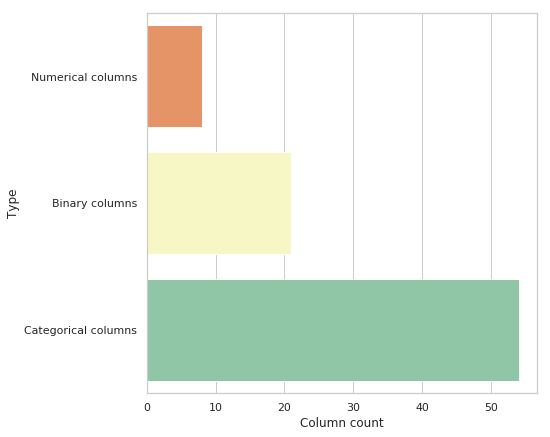

In [7]:
f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x="Column count", y="Type", data=type_df, label="Missing", palette='Spectral')
plt.show()

As we can see, there are far more categorical columns than numerical or binary.

### Null values count

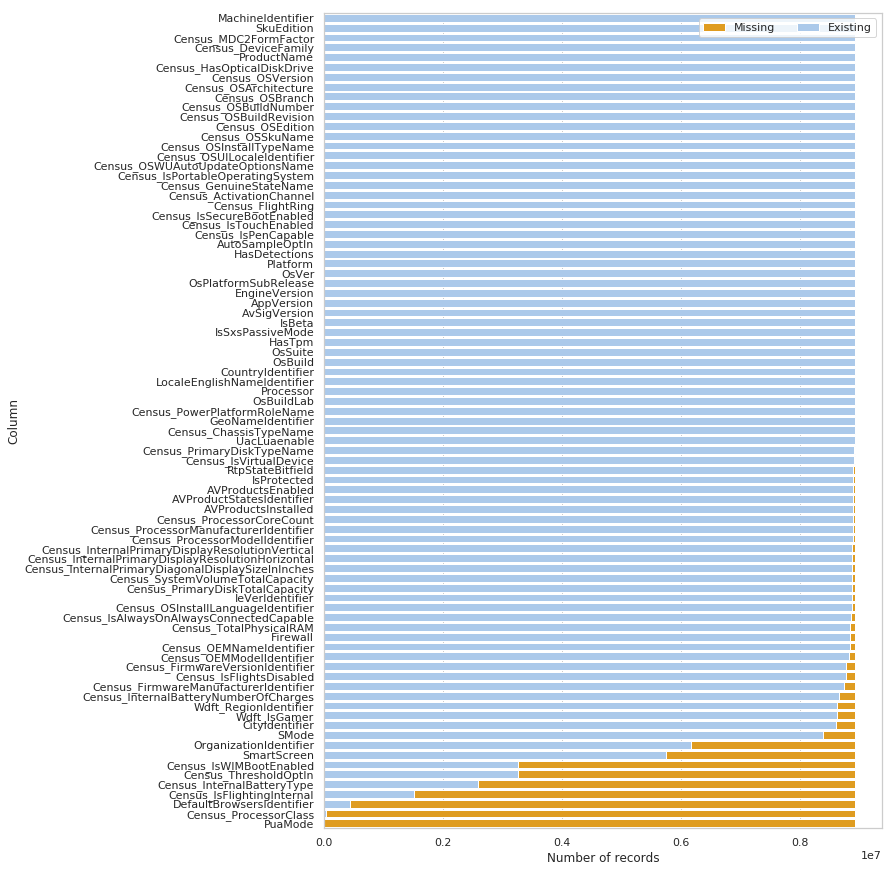

In [8]:
f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="Total", y="Column", data=missing_df, label="Missing", color="orange")
sns.barplot(x="Number of records", y="Column", data=missing_df, label="Existing", color="b")
ax.legend(ncol=2, loc="upper right", frameon=True)
plt.show()

 For most of the feature we don't have too many missing values to worry about, but we have 7 features with more than 50% missing values, probably would be a good idea to remove them.

### Column cardinality
* Only shown columns with cardinalities greater than 2

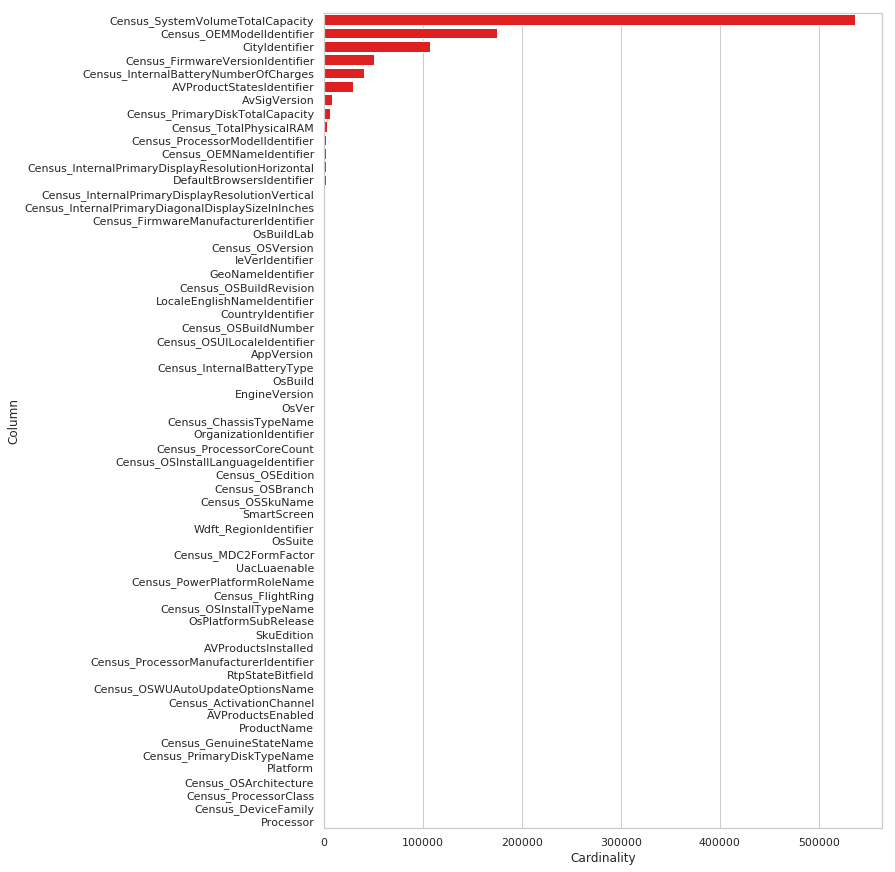

In [9]:
f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="Cardinality", y="Column", data=cardinality_df, label="Existing", color="red")
plt.show()

Some of the features have too many categorical values (high cardinality), this can be a problem to some models, if you one-hot encode them you will end up with features too sparse, as this is a simple iteration I'll remove those features.

### Label count

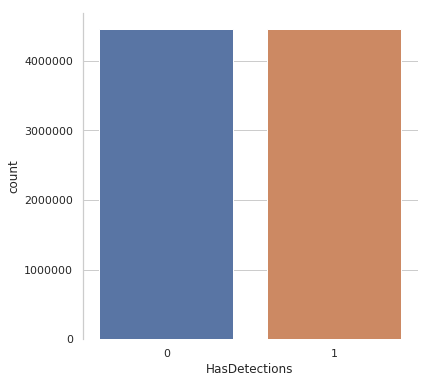

In [10]:
f, ax = plt.subplots(figsize=(6, 6))
ax = sns.countplot(x="HasDetections", data=train, label="Label count")
sns.despine(bottom=True)

Fortunately our label is balanced, this will make things easier for us.

## Pre process
### Clean data
#### Remove columns with high cardinality (more than 500 categories)

In [11]:
high_cardinality_columns = [c for c in categorical_columns if train[c].nunique() > 500]
high_cardinality_columns.remove('MachineIdentifier')  # Remove ID
train.drop(high_cardinality_columns, axis=1, inplace=True)
print('Columns with high cardinality: ', high_cardinality_columns)

Columns with high cardinality:  ['AvSigVersion', 'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier', 'CityIdentifier', 'OsBuildLab', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorModelIdentifier', 'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier']


#### Remove columns with more than 40% missing data

In [12]:
high_null_columns = [c for c in train.columns if train[c].count() < len(train)*0.6]
train.drop(high_null_columns, axis=1, inplace=True)
print('Columns with more than 40% null values: ', high_null_columns)

Columns with more than 40% null values:  ['PuaMode', 'Census_ProcessorClass', 'Census_InternalBatteryType', 'Census_IsFlightingInternal', 'Census_ThresholdOptIn', 'Census_IsWIMBootEnabled']


#### Remove unwanted columns

In [13]:
unwanted_columns = ['MachineIdentifier']
train.drop(unwanted_columns, axis=1, inplace=True)

In [14]:
# Remove rows from numeric features with missing values (need this to plot distributions)
train.dropna(subset=true_numerical_columns, inplace=True)

## Exploratory Data Analysis [2nd part, clean data]

### Correlate version and build features with the label

I had an initial hypothesis that devices with older versions or builds would have more malware, since their vulnerabilities probably would be more well known, and could be used for malicious ends.

In [15]:
binary_columns, true_numerical_columns, categorical_columns = update_feature_lists()

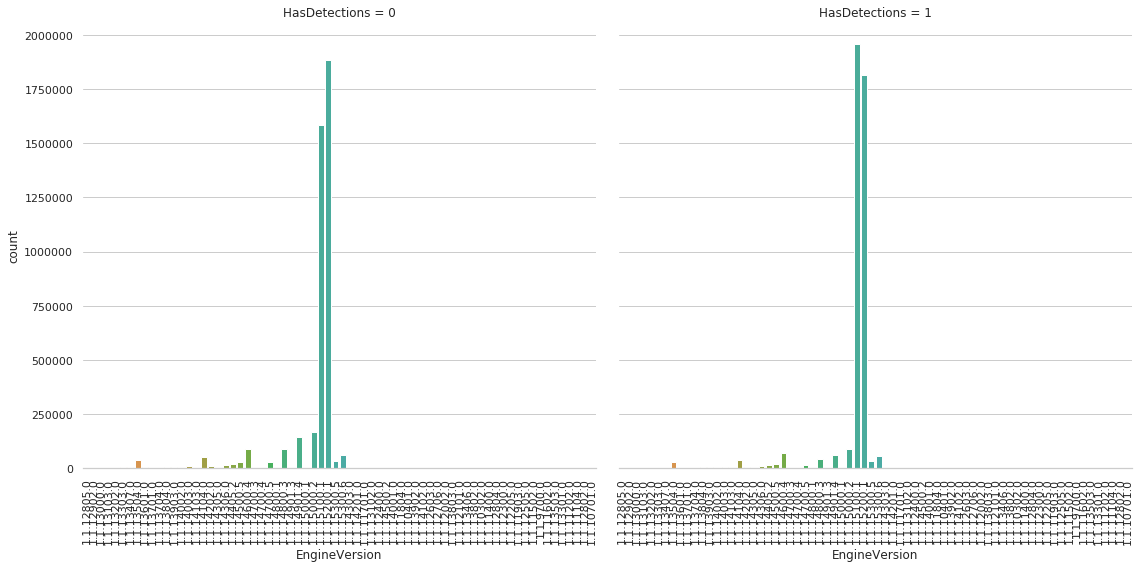

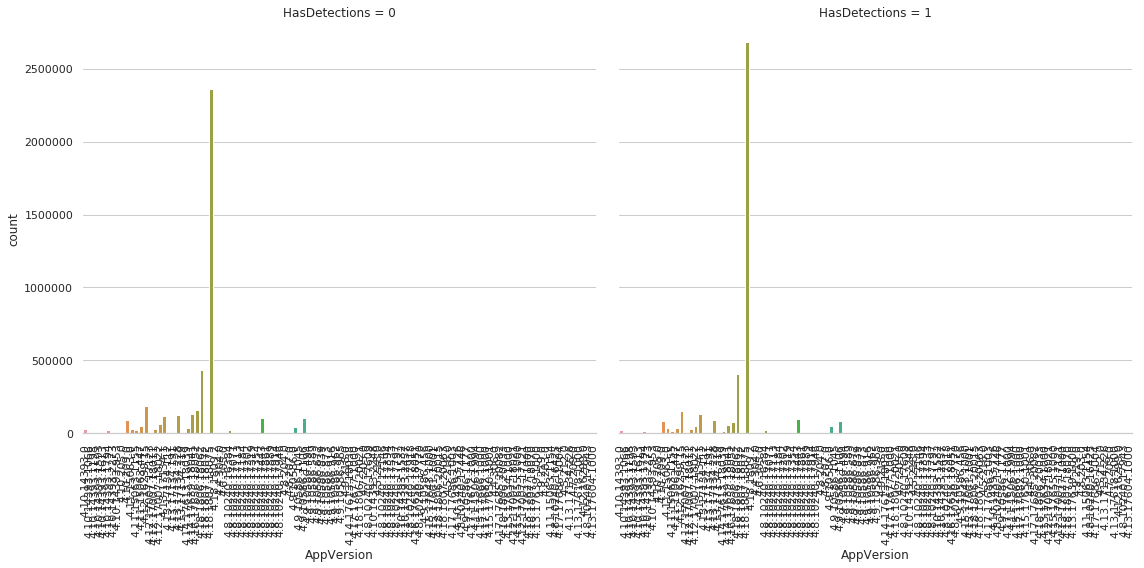

In [16]:
def plot_label_distribution():
    for feature in (binary_columns + categorical_columns):
        if 'Version' in feature and feature != 'Census_OSVersion':
            sns.catplot(data=train, x=feature, col="HasDetections", kind="count", height=8).set_xticklabels(rotation=90)
            sns.despine(left=True)
            plt.tight_layout()

plot_label_distribution()

### About the features related to Version
* EngineVersion and AppVersion: Both distributions seems to be almost the same.

Also as you can see newer versions have less data.

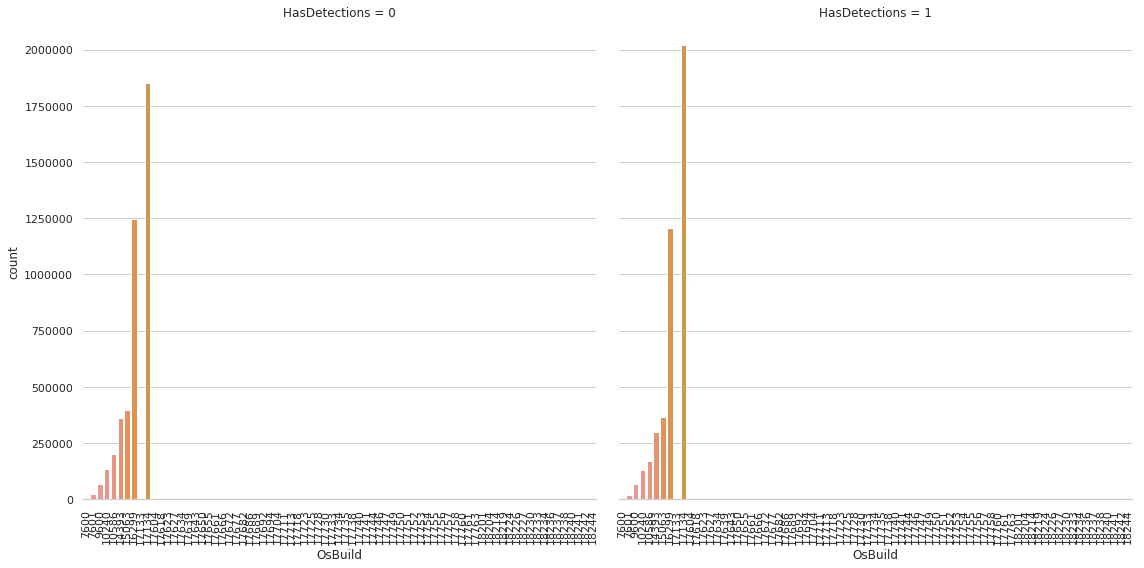

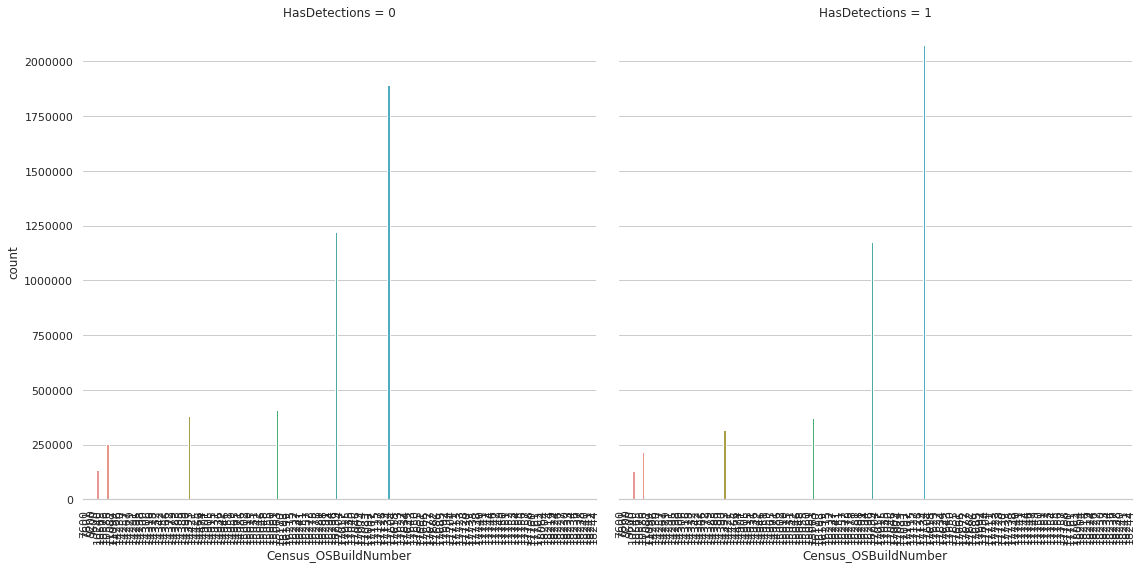

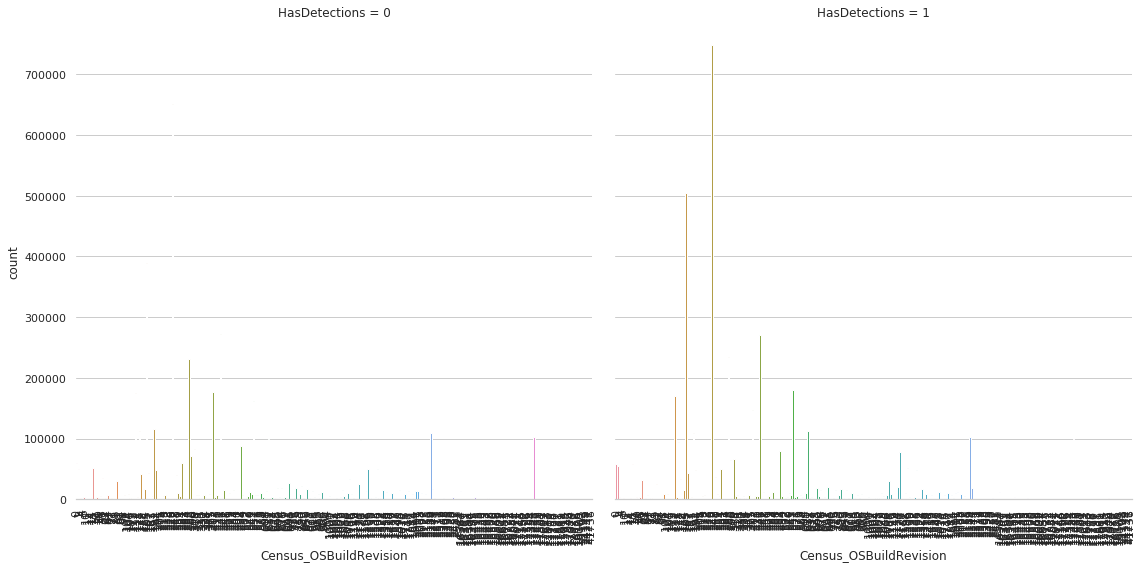

In [17]:
def plot_label_distribution():
    for feature in (binary_columns + categorical_columns):
        if 'Build' in feature and feature != 'OsBuildLab':
            sns.catplot(data=train, x=feature, col="HasDetections", kind="count", height=8).set_xticklabels(rotation=90)
            sns.despine(left=True)
            plt.tight_layout()

plot_label_distribution()

### About the features related to build
* OsBuild and Census_OSBuildNumber: Not much going on here, seems to be something close to 50% malware detection and 50% with no malware detection.
* Census_OSBuildRevision: Here things are more interesting, some categories have a similar label count, but some of them have a lot more of one label than the other.

**About my hypothesis: With those visualizations it's hard to validate or drop it, we don't have enough data on more recent version or build features to say if they are more secure than older ones.**

### Numeric columns distribution on the whole set and by label

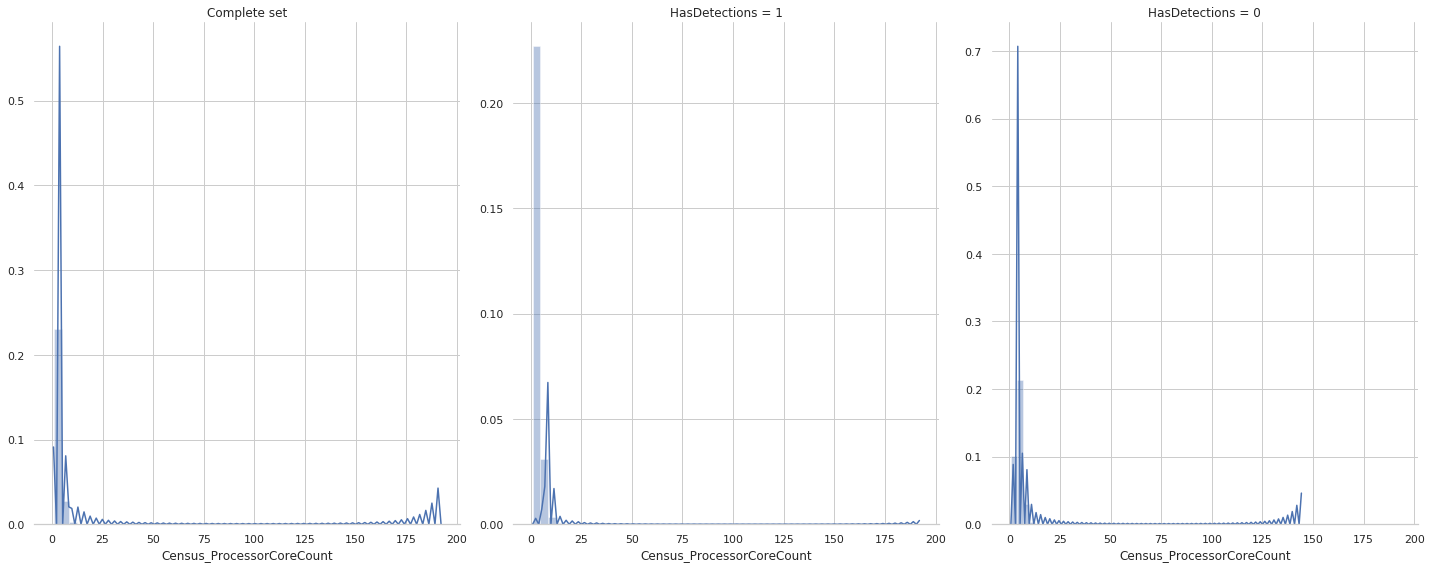

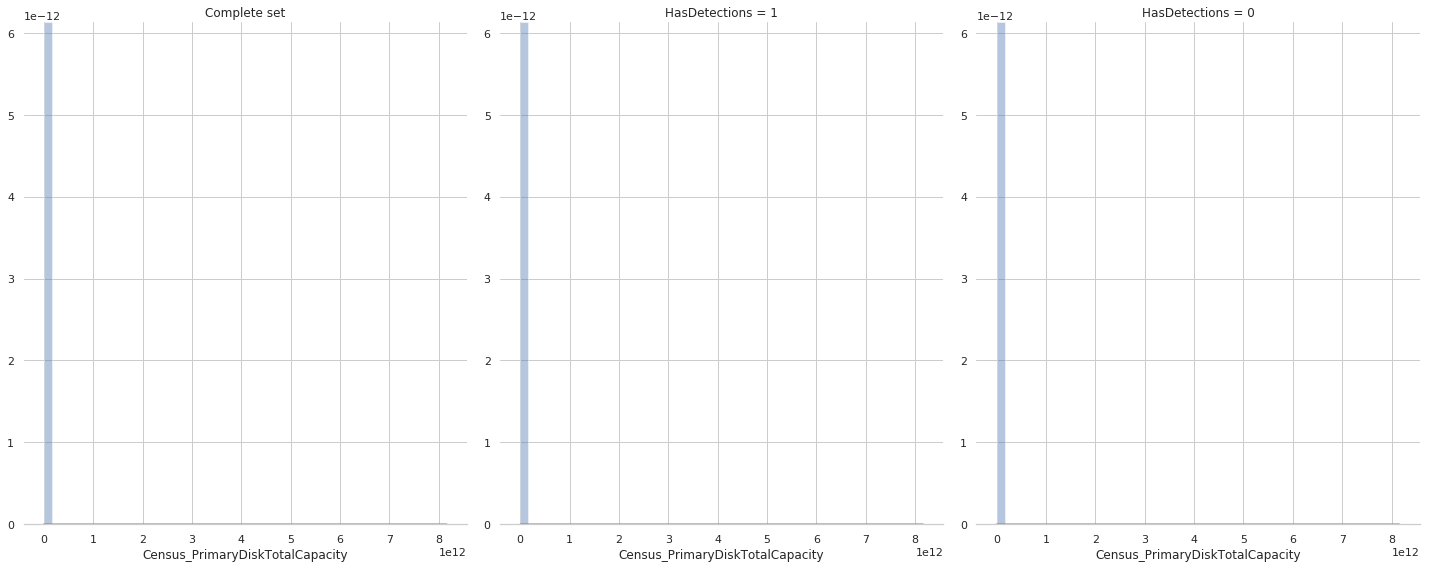

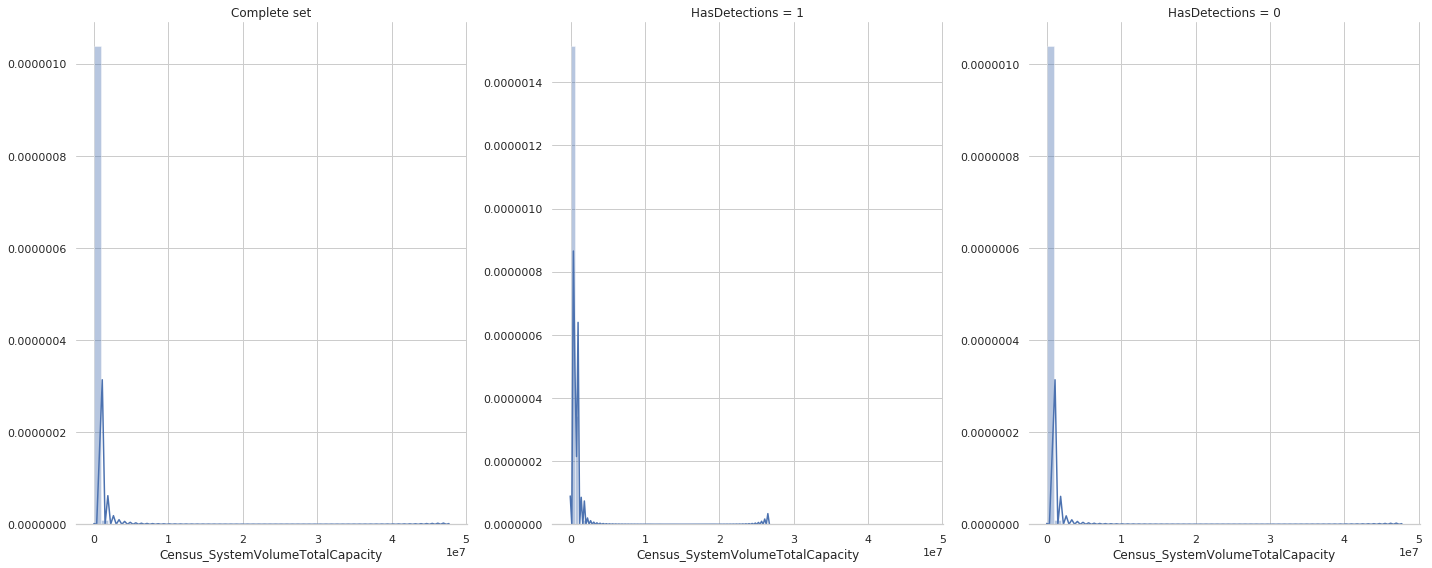

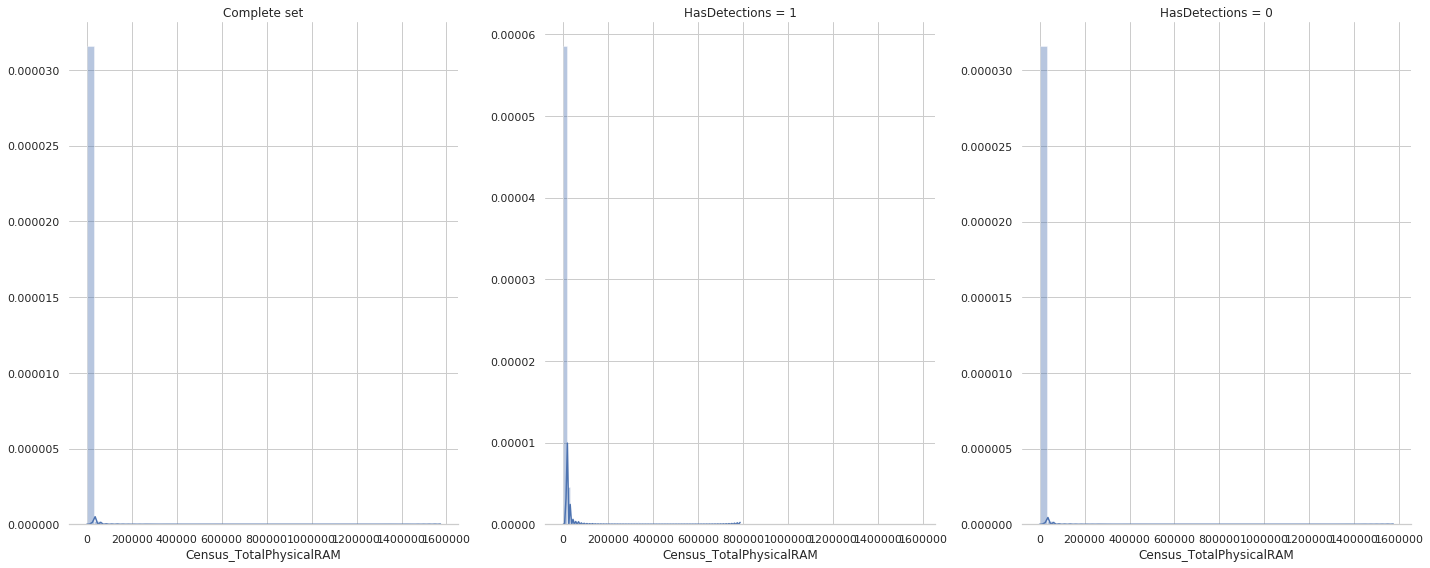

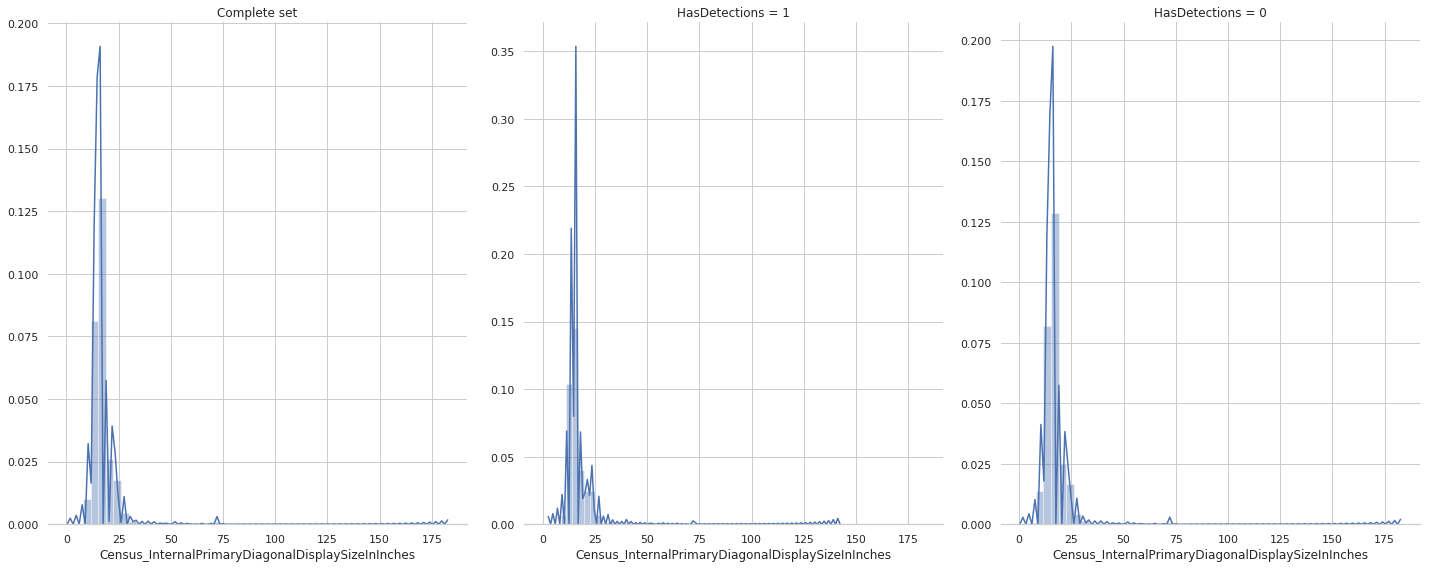

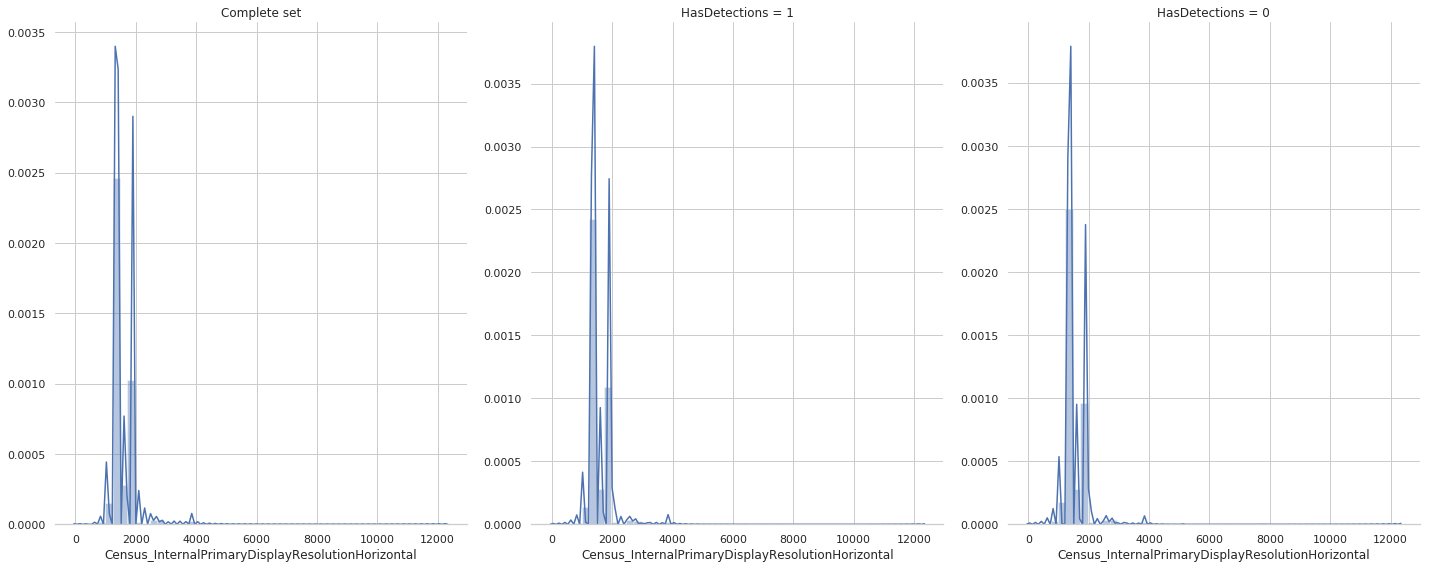

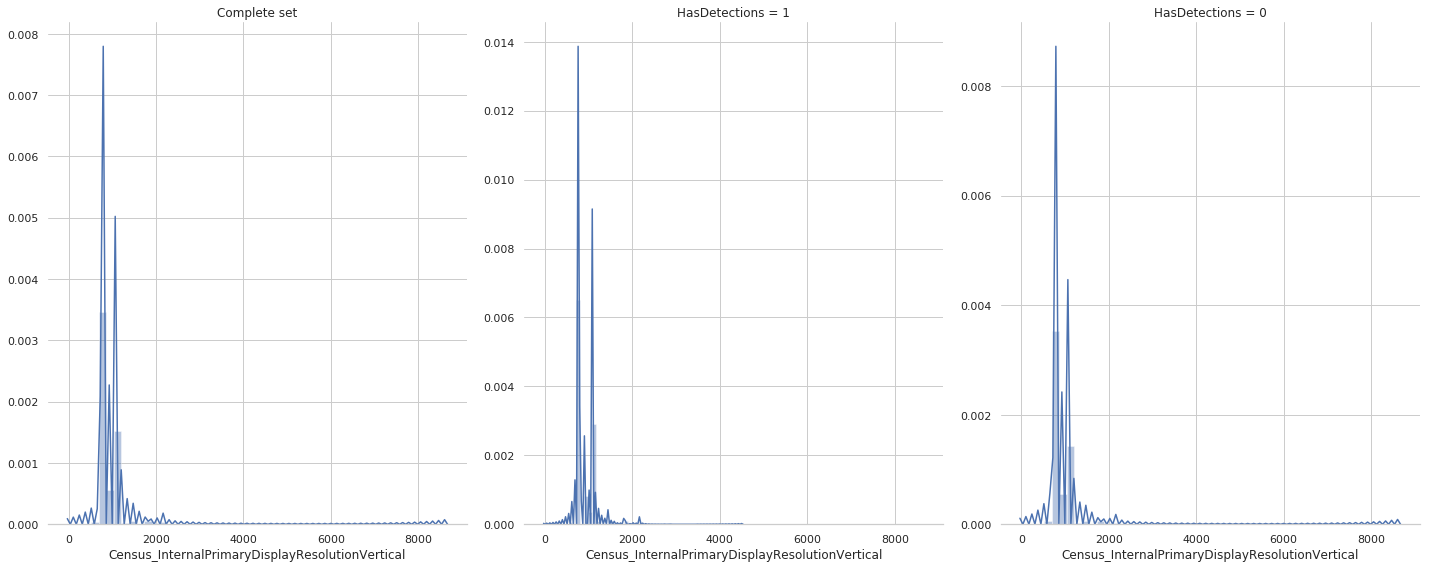

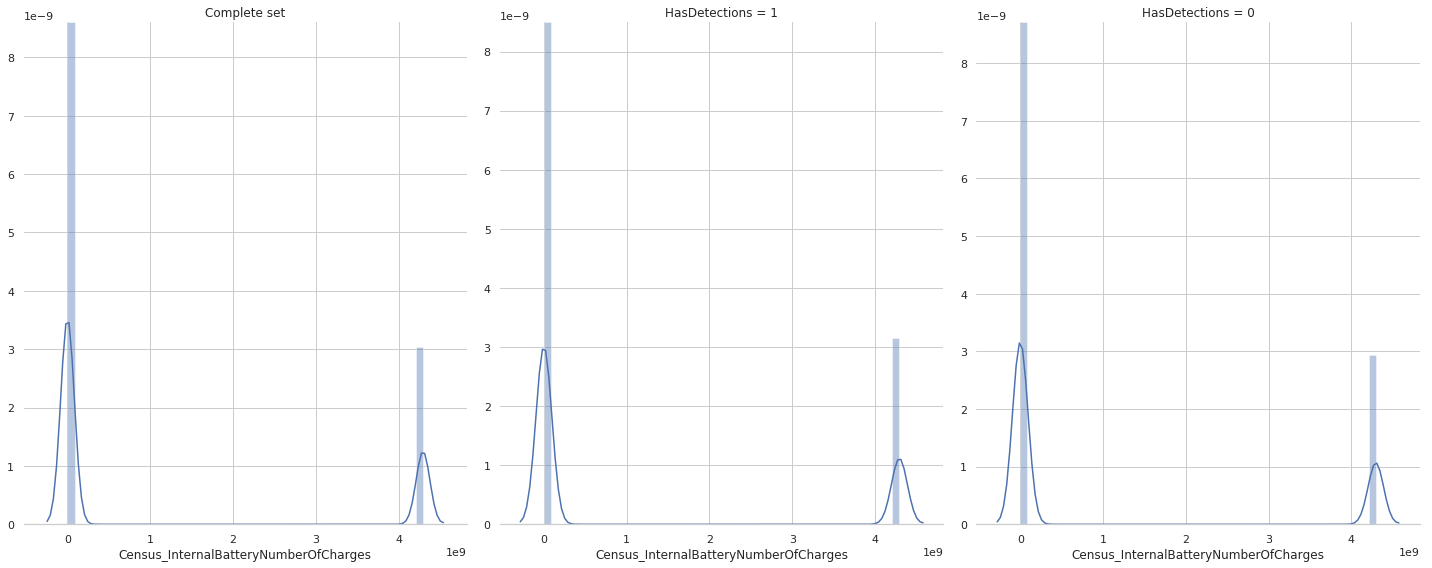

In [18]:
def plot_distribution():
    for feature in true_numerical_columns:
        f, axes = plt.subplots(1, 3, figsize=(20, 8), sharex=True)
        sns.distplot(train[feature], ax=axes[0]).set_title("Complete set")
        sns.distplot(train[train['HasDetections']==1][feature], ax=axes[1]).set_title("HasDetections = 1")
        sns.distplot(train[train['HasDetections']==0][feature], ax=axes[2]).set_title("HasDetections = 0")
        sns.despine(left=True)
        plt.tight_layout()

plot_distribution()

### About the features related to build
* Census_ProcessorCoreCount: Malware detection seems to more skewed towards right and non-detection are more concentrated on the first 10 values.
* Census_PrimaryDiskTotalCapacity: The distributions seems to be the same.
* Census_SystemVolumeTotalCapacity and Census_TotalPhysicalRAM: Malware detection seems to more concentrated on the beginning and non-detection seems to more skewed towards right.
* Census_InternalPrimaryDiagonalDisplaySizeInInches: The distributions are very similar but non-detection have a longer right tail.
* Census_InternalPrimaryDisplayResolutionHorizontal: The distributions seems to be the same.
* Census_InternalPrimaryDisplayResolutionVertical: The distributions are very similar but non-detection have a longer right tail.
* Census_InternalBatteryNumberOfCharges: The distributions seems to be the same.

In [19]:
train.head()

,ProductName,EngineVersion,AppVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,win8defender,1.1.15100.1,4.18.1807.18075,0,7.00,0,1.00,1.00,1,29,18.00,35.00,-85,windows10,x64,10.0.0.0,17134,256,rs4,Pro,1.00,0,0.00,137.00,NaN,1.00,1.00,Desktop,Windows.Desktop,4.00,5.00,476940.00,HDD,299451.00,0,4096.00,Desktop,18.91,1440.00,900.00,Desktop,4294967296.00,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.00,119,UNKNOWN,0,IS_GENUINE,Retail,0.00,Retail,0,0.00,0,0,0.00,0.00,10.00,0
1,win8defender,1.1.14600.4,4.13.17134.1,0,7.00,0,1.00,1.00,1,93,18.00,119.00,64,windows10,x64,10.0.0.0,17134,256,rs4,Pro,1.00,0,0.00,137.00,NaN,1.00,1.00,Notebook,Windows.Desktop,4.00,5.00,476940.00,HDD,102385.00,0,4096.00,Notebook,13.90,1366.00,768.00,Mobile,1.00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.00,31,UNKNOWN,0,OFFLINE,Retail,0.00,NOT_SET,0,0.00,0,0,0.00,0.00,8.00,0
2,win8defender,1.1.15100.1,4.18.1807.18075,0,7.00,0,1.00,1.00,1,86,18.00,64.00,49,windows10,x64,10.0.0.0,17134,768,rs4,Home,1.00,0,0.00,137.00,RequireAdmin,1.00,1.00,Desktop,Windows.Desktop,4.00,5.00,114473.00,SSD,113907.00,0,4096.00,Desktop,21.50,1920.00,1080.00,Desktop,4294967296.00,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.00,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,0.00,Retail,0,0.00,0,0,0.00,0.00,3.00,0
3,win8defender,1.1.15100.1,4.18.1807.18075,0,7.00,0,1.00,1.00,1,88,nan,117.00,115,windows10,x64,10.0.0.0,17134,256,rs4,Pro,1.00,0,0.00,137.00,ExistsNotSet,1.00,1.00,Desktop,Windows.Desktop,4.00,5.00,238475.00,UNKNOWN,227116.00,0,4096.00,MiniTower,18.50,1366.00,768.00,Desktop,4294967296.00,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.00,64,FullAuto,0,IS_GENUINE,OEM:NONSLP,0.00,Retail,0,0.00,0,0,0.00,0.00,3.00,1
4,win8defender,1.1.15100.1,4.18.1807.18075,0,7.00,0,1.00,1.00,1,18,nan,277.00,75,windows10,x64,10.0.0.0,17134,768,rs4,Home,1.00,0,0.00,137.00,RequireAdmin,1.00,1.00,Notebook,Windows.Desktop,4.00,5.00,476940.00,HDD,101900.00,0,6144.00,Portable,14.00,1366.00,768.00,Mobile,0.00,10.0.17134.191,amd64,rs4_release,17134,191,Core,CORE,Update,8.00,31,FullAuto,0,IS_GENUINE,Retail,0.00,Retail,0,0.00,0,0,0.00,0.00,1.00,1


In [20]:
train[true_numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
Census_ProcessorCoreCount,8585688.00,nan,0.00,1.00,2.00,4.00,4.00,192.00
Census_PrimaryDiskTotalCapacity,8585688.00,3006892.50,4524349440.00,0.00,239372.00,476940.00,953869.00,8160436813824.00
Census_SystemVolumeTotalCapacity,8585688.00,382814.78,323253.44,0.00,120815.00,249604.00,475978.00,47687100.00
Census_TotalPhysicalRAM,8585688.00,6124.35,4987.17,255.00,4096.00,4096.00,8192.00,1572864.00
Census_InternalPrimaryDiagonalDisplaySizeInInches,8585688.00,nan,0.00,0.70,13.90,15.50,17.20,182.25
Census_InternalPrimaryDisplayResolutionHorizontal,8585688.00,nan,nan,-1.00,1366.00,1366.00,1920.00,12288.00
Census_InternalPrimaryDisplayResolutionVertical,8585688.00,nan,nan,-1.00,768.00,768.00,1080.00,8640.00
Census_InternalBatteryNumberOfCharges,8585688.00,1122106240.00,1931297920.00,0.00,0.00,0.00,4294967296.00,4294967296.00


## Process data for LGB model

In [21]:
# Remove rows with NA
train.dropna(inplace=True)

### Train/validation random split (85% train / 15% validation)

In [22]:
# Get labels
labels = train['HasDetections']
train.drop('HasDetections', axis=1, inplace=True)

X_train, X_val, Y_train, Y_val = train_test_split(train, labels, test_size=0.15,random_state=1)

In [23]:
binary_columns, true_numerical_columns, categorical_columns = update_feature_lists()

# Label encoder
indexer = {}
for col in categorical_columns:
    _, indexer[col] = pd.factorize(X_train[col])
    
for col in categorical_columns:
    X_train[col] = indexer[col].get_indexer(X_train[col])
    X_val[col] = indexer[col].get_indexer(X_val[col])

In [24]:
params = {'num_leaves': 60,
         'min_data_in_leaf': 100, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 1,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

In [25]:
lgb_train = lgb.Dataset(X_train, label=Y_train)
lgb_val = lgb.Dataset(X_val, label=Y_val)

## Model training

In [26]:
model = lgb.train(params, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.740714	valid_1's auc: 0.739763
[200]	training's auc: 0.745852	valid_1's auc: 0.743594
[300]	training's auc: 0.74861	valid_1's auc: 0.744886
[400]	training's auc: 0.750917	valid_1's auc: 0.745755
[500]	training's auc: 0.752866	valid_1's auc: 0.74628
[600]	training's auc: 0.754752	valid_1's auc: 0.74674
[700]	training's auc: 0.756449	valid_1's auc: 0.747024
[800]	training's auc: 0.758062	valid_1's auc: 0.747296
[900]	training's auc: 0.75964	valid_1's auc: 0.747511
[1000]	training's auc: 0.761146	valid_1's auc: 0.747712
[1100]	training's auc: 0.762516	valid_1's auc: 0.747809
[1200]	training's auc: 0.763866	valid_1's auc: 0.747948
[1300]	training's auc: 0.765166	valid_1's auc: 0.747985
[1400]	training's auc: 0.766458	valid_1's auc: 0.748086
[1500]	training's auc: 0.767679	valid_1's auc: 0.748094
[1600]	training's auc: 0.768929	valid_1's auc: 0.748172
[1700]	training's auc: 0.770185	valid_1's auc: 0.74821

### Model feature importance

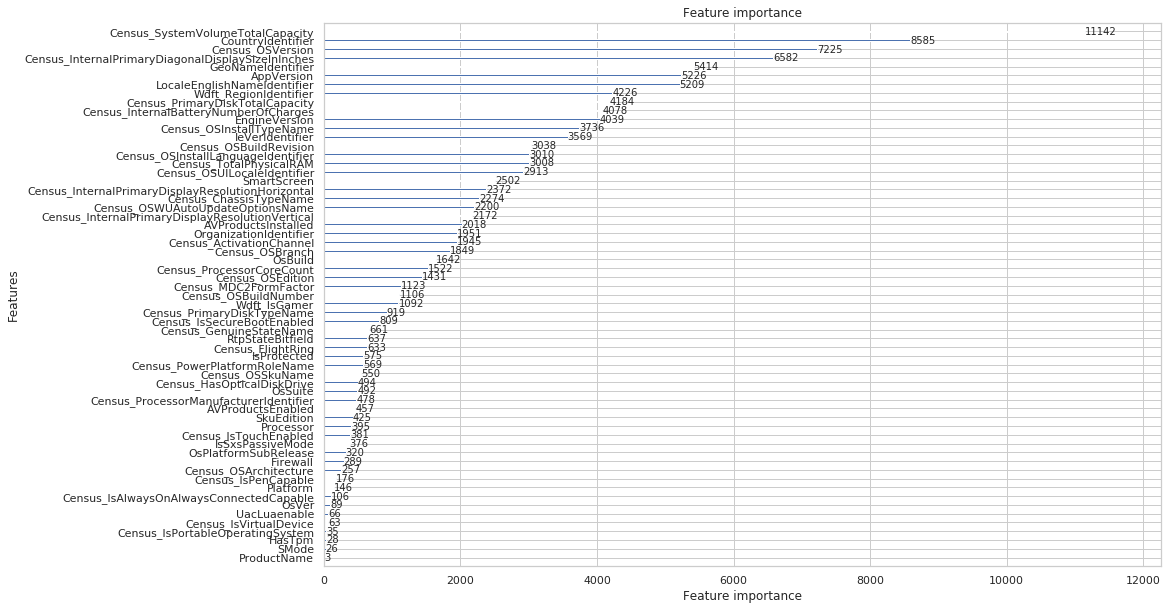

In [27]:
lgb.plot_importance(model, figsize=(15, 10))
plt.show()

In [28]:
train_predictions_raw = model.predict(X_train, num_iteration=model.best_iteration)
val_predictions_raw = model.predict(X_val, num_iteration=model.best_iteration)

train_predictions = np.around(train_predictions_raw)
val_predictions = np.around(val_predictions_raw)

### Model metrics

In [29]:
target_names=['HasDetections = 0', 'HasDetections = 1']
print('-----Train-----')
print(classification_report(Y_train, train_predictions, target_names=target_names))
print('-----Validation-----')
print(classification_report(Y_val, val_predictions, target_names=target_names))

-----Train-----
                   precision    recall  f1-score   support

HasDetections = 0       0.68      0.71      0.70   1409602
HasDetections = 1       0.72      0.68      0.70   1510157

        micro avg       0.70      0.70      0.70   2919759
        macro avg       0.70      0.70      0.70   2919759
     weighted avg       0.70      0.70      0.70   2919759

-----Validation-----
                   precision    recall  f1-score   support

HasDetections = 0       0.66      0.69      0.68    249299
HasDetections = 1       0.70      0.66      0.68    265953

        micro avg       0.68      0.68      0.68    515252
        macro avg       0.68      0.68      0.68    515252
     weighted avg       0.68      0.68      0.68    515252



### Confusion matrix

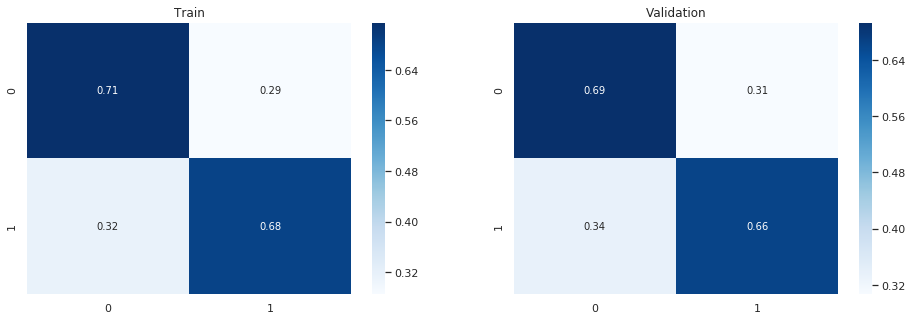

In [30]:
f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(Y_train, train_predictions)
val_cnf_matrix = confusion_matrix(Y_val, val_predictions)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
val_cnf_matrix_norm = val_cnf_matrix / val_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
val_df_cm = pd.DataFrame(val_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=axes[0]).set_title("Train")
sns.heatmap(val_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=axes[1]).set_title("Validation")
plt.show()

### Probabilities distribution
* One thing that is often overlooked is the output probability from the models, this can help you see how confident your model is about it's predictions.
* From your model probability distribution what you would like to see is a higher distribution on the extremes that would mean high probability of class 0 or 1, lots of values on the middle can mean that your model don't high confidence about it's predictions.

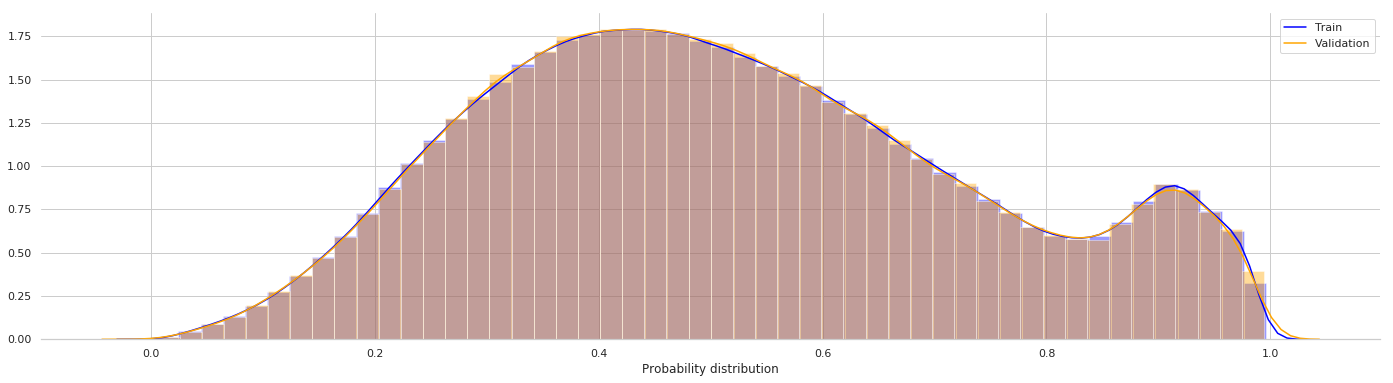

In [31]:
f, ax = plt.subplots(figsize=(24, 6))
sns.set_color_codes("pastel")
ax = sns.distplot(train_predictions_raw, color="blue", kde_kws={"label": "Train"}, axlabel='Probability distribution')
ax = sns.distplot(val_predictions_raw, color="orange", kde_kws={"label": "Validation"})
sns.despine(left=True)

## Predictions

### Load test set

In [32]:
# Because of memory issues I'm loading only part of test set.
test = dd.read_csv('../input/test.csv', dtype=dtypes, usecols=(['MachineIdentifier'] + list(X_train.columns))).head(n=1000000)

### Pre process test

In [33]:
submission = pd.DataFrame({"MachineIdentifier":test['MachineIdentifier']})
test.drop('MachineIdentifier', axis=1, inplace=True)

for col in categorical_columns:
    test[col] = indexer[col].get_indexer(test[col])

### Make predictions

In [34]:
predictions = model.predict(test, num_iteration=model.best_iteration)

## Output results

In [35]:
submission["HasDetections"] = predictions
submission.to_csv("submission.csv", index=False)
submission.head(10)

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.94
1,00000176ac758d54827acd545b6315a5,0.29
2,0000019dcefc128c2d4387c1273dae1d,0.29
3,0000055553dc51b1295785415f1a224d,0.36
4,00000574cefffeca83ec8adf9285b2bf,0.47
5,000007ffedd31948f08e6c16da31f6d1,0.77
6,000008f31610018d898e5f315cdf1bd1,0.63
7,00000a3c447250626dbcc628c9cbc460,0.52
8,00000b6bf217ec9aef0f68d5c6705897,0.78
9,00000b8d3776b13e93ad83676a28e4aa,0.31
